In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import pdb
import scipy
import matplotlib.pyplot as plt
import sys
import pandas as pd
import pickle
import sdeint
import torch
from glob import glob
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.lqg import LQGComponentsAnalysis as LQGCA
from tqdm import tqdm

In [9]:
sys.path.append('/home/akumar/nse/neural_control')

In [10]:
from soc import stabilize, gen_init_W, stabilize_discrete, comm_mat

In [11]:
from utils import apply_df_filters

### Continuous time optimization

In [18]:
np.linspace(0.75, 10, 25)

array([ 0.75      ,  1.13541667,  1.52083333,  1.90625   ,  2.29166667,
        2.67708333,  3.0625    ,  3.44791667,  3.83333333,  4.21875   ,
        4.60416667,  4.98958333,  5.375     ,  5.76041667,  6.14583333,
        6.53125   ,  6.91666667,  7.30208333,  7.6875    ,  8.07291667,
        8.45833333,  8.84375   ,  9.22916667,  9.61458333, 10.        ])

In [19]:
reps = 20
inner_reps = 10
M = 100
p = 0.25
gamma = np.array([2])
R = np.linspace(0.75, 10, 25)
dt = 1

In [7]:
# In order to illustrate the desired effect, we vary along several parameters. (1) is the degree to which connections within and between blocks are asymmetric.
# (2) gamma, R
# 

phi = np.zeros((reps, gamma.size, R.size, inner_reps))
scores = np.zeros((reps, gamma.size, R.size, inner_reps))

nn = np.zeros((reps, gamma.size, R.size, 2))

for rep in range(reps):
    for i, g in enumerate(gamma):
        for j, r in tqdm(enumerate(R)):
            A = gen_init_W(M, p, g, r, -1)
            eig = np.linalg.eigvals(A)
            if np.max(np.real(eig)) >= 0:
                A = stabilize(A)
                eig = np.linalg.eigvals(A)

            assert(np.max(np.real(eig)) < 0)

            # Scale down - this causes problems
            A /= 10

            # Generate data using this model; both linear and nonlinear activation functions
            
            # In the linear case, we can calculate the autocorrelation matrices exactly, so might as well do that for now.
            
            # Stability optimize the spectral radius

            # # Use a Tustin discretization of the state space parameter
            B = np.eye(A.shape[0])
            C = np.eye(A.shape[0])


            sigma = 2/dt
            #Ad = (sigma * np.eye(A.shape[0]) + A) @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)
            #Ad = A + np.eye(A.shape[0])
            #Bd = np.sqrt(2 * sigma) * np.linalg.inv(sigma * np.eye(A.shape[0]) - A) @ B
            #Cd = np.sqrt(2 * sigma) * C @ np.linalg.inv(sigma * np.eye(A.shape[0]) - A)

            # assert(np.max(np.abs(np.linalg.eigvals(Ad))) < 1)

            Bd = B
            Cd = C

            nn[rep, i, j, 0] = np.linalg.norm(A @ A.T - A.T @ A)

            # Solve for the exact covarinace function and evaluate it at intervals of dt
            Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
            t_ = [j * dt for j in range(10)]
            cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

            d = 6
            # ssr = SSR(A=Ad, B=Bd, C=Cd)
            # cross_covs = ssr.autocorrelation(10)
            cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

            cross_covs = torch.tensor(cross_covs)
            cross_covs_rev = torch.tensor(cross_covs_rev)

            e, Upca = np.linalg.eig(cross_covs[0])
            eigorder = np.argsort(e)[::-1]
            Upca = Upca[:, eigorder][:, 0:d]

            lqgmodel = LQGCA(d=d, T=4)
            lqgmodel.cross_covs = cross_covs
            lqgmodel.cross_covs_rev = cross_covs_rev

            for k in range(inner_reps):
                coef_, score = lqgmodel._fit_projection()
                phi[rep, i, j, k] = np.mean(scipy.linalg.subspace_angles(Upca, coef_))
                scores[rep, i, j, k] = score            
            

0it [00:00, ?it/s]/tmp/ipykernel_26310/687149710.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)
25it [01:58,  4.75s/it]
25it [01:59,  4.76s/it]
25it [01:58,  4.72s/it]
25it [01:59,  4.79s/it]
25it [01:58,  4.74s/it]
25it [01:58,  4.75s/it]
25it [01:59,  4.78s/it]
25it [01:59,  4.80s/it]
25it [01:57,  4.70s/it]
25it [01:58,  4.75s/it]
25it [02:00,  4.80s/it]
25it [01:59,  4.76s/it]
25it [01:58,  4.75s/it]
25it [01:58,  4.73s/it]
25it [01:58,  4.72s/it]
25it [01:57,  4.70s/it]
25it [02:05,  5.02s/it]
25it [02:05,  5.02s/it]
25it [02:09,  5.18s/it]
25it [02:09,  5.16s/it]


In [6]:
import pickle

In [17]:
# with open('soc_sim.pkl', 'wb') as f:
#     f.write(pickle.dumps(phi))
#     f.write(pickle.dumps(nn))
#     f.write(pickle.dumps(scores))

with open('soc_sim.pkl', 'rb') as f:
    phi = pickle.load(f)
    nn = pickle.load(f)
    scores = pickle.load(f)

In [8]:
phi.shape

(20, 3, 25, 10)

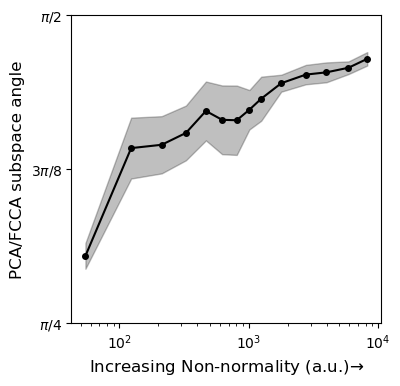

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))

gidx = 0

# Plot just a subset of the dots to not crowd the RHS
idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 16, 20, 24]

ax.plot(np.mean(nn[..., 0], axis=0)[gidx, idxs], np.mean(np.mean(phi, axis=-1), axis=0)[gidx, idxs], '-o', color='k', markersize=4)
ax.fill_between(np.mean(nn[..., 0], axis=0)[gidx, idxs], np.mean(np.mean(phi, axis=-1), axis=0)[gidx, idxs] - np.std(np.mean(phi, axis=-1), axis=0)[gidx, idxs], 
                np.mean(np.mean(phi, axis=-1), axis=0)[gidx, idxs] + np.std(np.mean(phi, axis=-1), axis=0)[gidx, idxs], alpha=0.25, color='k')
ax.set_xscale('log')

ax.set_ylim([np.pi/4, np.pi/2])
ax.set_yticks([np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_yticklabels([r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
#ax.set_xticklabels([])

ax.set_ylabel('PCA/FCCA subspace angle', fontsize=12)
ax.set_xlabel('Increasing Non-normality (a.u.)' + r'$\to$', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/soc_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Might be something here if we play with the parameters a bit more

In [20]:
eigvals = np.zeros((len(gamma), len(R), 2 * M)).astype(np.complex)
W = []
for i, g in enumerate(gamma):
    W.append([])
    for j, r in tqdm(enumerate(R)):
        A = gen_init_W(M, p, g, r, -1)
        eig = np.linalg.eigvals(A)
        if np.max(np.real(eig)) >= 0:
            A = stabilize(A)
            eig = np.linalg.eigvals(A)

        eigvals[i, j, :] = eig
        # Scale down by a factor of 10 to match the empirical eigenvalue range
        W[i].append(A/10)

/tmp/ipykernel_5566/3579978348.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eigvals = np.zeros((len(gamma), len(R), 2 * M)).astype(np.complex)
0it [00:00, ?it/s]

25it [00:49,  1.96s/it]


In [10]:
# Calculate the associated pseudospectra
from pseudopy.nonnormal import NonnormalAuto
from pseudopy.normal import Normal

In [22]:
nn1 = NonnormalAuto(W[0][0], 1e-5, 1)

In [23]:
nn2 = NonnormalAuto(W[0][12], 1e-5, 1)

In [24]:
nn3 = NonnormalAuto(W[0][24], 1e-5, 1)

In [7]:
import pickle

In [11]:
# with open('soc_pseudo2.pkl', 'wb') as f:
#     f.write(pickle.dumps(W))
#     f.write(pickle.dumps(nn1))
#     f.write(pickle.dumps(nn2))
#     f.write(pickle.dumps(nn3))

with open('soc_pseudo2.pkl', 'rb') as f:
    W = pickle.load(f)
    nn1 = pickle.load(f)
    nn2 = pickle.load(f)
    nn3 = pickle.load(f)

In [12]:
n1 = Normal(W[0][0])
n2 = Normal(W[0][12])
n3 = Normal(W[0][24])

In [25]:
nnobj = nn3
nobj = n3
A_ = W[0][24]

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


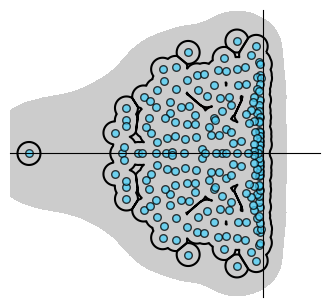

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = [1e-6, 0.1]

ax.tricontourf(nnobj.triang, nnobj.vals, levels=levels, colors=['k'], alpha=0.2)
ax.scatter(np.real(np.linalg.eigvals(A_)), np.imag(np.linalg.eigvals(A_)), s=30, alpha=0.75, marker='o', edgecolor='k', color='#4dd2fa')
#nn1 = NonnormalAuto(W[0][0], 1e-5, 1)
epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = nobj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-2.2, 0.5])
ax.set_ylim([-1.25, 1.25])
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_aspect('equal')
ax.tick_params(axis='both', labelsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/soc1c.pdf', bbox_inches='tight', pad_inches=0)

In [47]:
# Plot example trajectories from each system
def gen_activity(tau, W, activ_func, sigma, T, h):

    # f
    def f_(x, t):
        return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return sigma * np.eye(W.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    
    x0 = np.random.normal(size=(W.shape[0],))

    return  sdeint.itoSRI2(f_, g_, x0, tspace)    

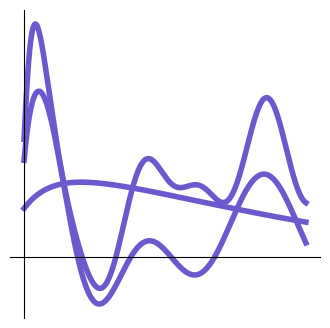

In [49]:
fig, ax = plt.subplots(figsize=(4, 4))

for i, A in enumerate([W[0][0], W[0][12], W[0][24]]):
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
    eig, U = np.linalg.eig(Pi)
    eigorder = np.argsort(eig)[::-1]
    U = U[:, eigorder]
    U = U[:, 0][:, np.newaxis]

    # Simulate from A with unit vector initial condition
    def f(y, t):
        return A @ y

    y = scipy.integrate.odeint(f, 1/np.sqrt(A.shape[0]) * np.ones(A.shape[0]), np.linspace(0, 150, 10000))
    
    #yproj = np.abs(y @ U)
    # Start at the same point
    #yproj -= yproj[0] - 0.1

    # Manually adjust
    if i == 0:
        pass
        yproj = y[:2000, 0]
        yproj -= 0.04
    if i == 1:
        yproj = y[:2000, 14]
        yproj += 0.04
    if i == 2:
        yproj = y[:2000, 0]
        yproj += 0.075

    ax.plot(yproj, color='slateblue', linewidth=4)

ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position(('data', -0.05))

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('soc_trajectories.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# In a subsequent analysis, we then look at rotational dynamics found in each of the subspaces. This will then feed into an analysis of the one timestep problem and a more
# intuitive analysis of why one expects rotational dynamics to be feedback controllable

In [ ]:
# What about rank of the input?

In [ ]:
# (1) Verify that the W generation protocol adopted gives rise to the expected spectral radius

# (2) When simulating, figure out how to do time discretization. Key is to have time symmetric autocorrelation matrices in the case of interest

In [ ]:
# testing discrete stabilization

### Discrete time optimization

In [5]:
A = gen_init_W(20, 0.9, 1., 1.)
C = 1.01
n = A.shape[0]

alpha_e = C * np.max(np.abs(np.linalg.eigvals(A)))
P = scipy.linalg.solve_discrete_lyapunov(A/alpha_e, np.eye(n))
K = comm_mat(n, n)

# Note in the last term, we include a factor of alpha_e squared since we also pulled it out of the dA term
jac = np.linalg.inv(np.eye(n**2)- np.kron(A/alpha_e, A/alpha_e)) @ (np.kron(A/alpha_e**2 @ P, np.eye(n)) + np.kron(np.eye(n), A @ P/alpha_e**2) @ K)

grad = (np.eye(n).flatten().T @ jac).reshape((n, n), order='F')

In [6]:
inh_idx = np.argwhere(A < 0)

# Take the largest step size that still decreases the trace
eta = np.logspace(-8, -1, 50)
tr = np.zeros(eta.size)
for i in range(eta.size):
    Ap = np.zeros(A.shape)
    for idx in inh_idx:
        Ap[idx[0], idx[1]] = A[idx[0], idx[1]] - eta[i] * grad[idx[0], idx[1]]

    tr[i] = np.trace(scipy.linalg.solve_discrete_lyapunov(Ap/alpha_e, np.eye(n)))        

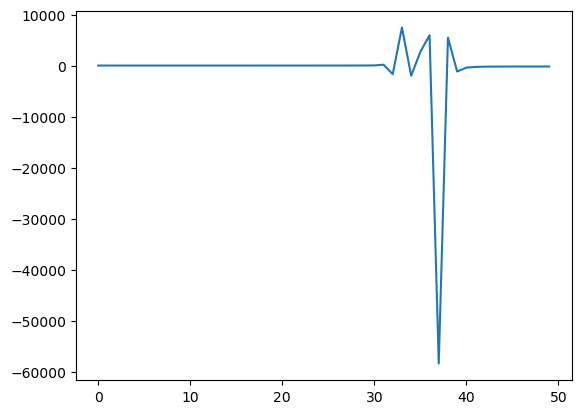

In [7]:
plt.plot(tr)

In [8]:
np.argmin(tr)

37

In [9]:
As = stabilize_discrete(A, C=1.01, max_iter=10000)

iter_:0, alpha:2.917998
iter_:1, alpha:42.467617
iter_:2, alpha:42.359033
iter_:3, alpha:42.250127
iter_:4, alpha:42.140893
iter_:5, alpha:42.031329
iter_:6, alpha:41.921431
iter_:7, alpha:41.811197
iter_:8, alpha:41.700623
iter_:9, alpha:41.589705
iter_:10, alpha:41.478439
iter_:11, alpha:41.366823
iter_:12, alpha:41.254853
iter_:13, alpha:41.142524
iter_:14, alpha:41.029833
iter_:15, alpha:40.916776
iter_:16, alpha:40.803350
iter_:17, alpha:40.689550
iter_:18, alpha:40.575372
iter_:19, alpha:40.460811
iter_:20, alpha:40.345865
iter_:21, alpha:40.230527
iter_:22, alpha:40.114795
iter_:23, alpha:39.998663
iter_:24, alpha:39.882126
iter_:25, alpha:39.765181
iter_:26, alpha:39.647822
iter_:27, alpha:39.530044
iter_:28, alpha:39.411843
iter_:29, alpha:39.293213
iter_:30, alpha:39.174149
iter_:31, alpha:39.054645
iter_:32, alpha:38.934697
iter_:33, alpha:38.814299
iter_:34, alpha:38.693444
iter_:35, alpha:38.572128
iter_:36, alpha:38.450344
iter_:37, alpha:38.328086
iter_:38, alpha:38.2053

array([2.50658475, 2.50658475, 2.20770785, 2.20770785, 1.71926116,
       1.71926116, 1.93377617, 1.78917436, 1.78917436, 1.38165686,
       1.10990205, 1.10990205, 0.65437574, 0.65437574, 1.04142551,
       1.04142551, 0.85808857, 0.85808857, 0.6634707 , 0.6634707 ])

In [43]:
np.abs(np.linalg.eigvals(As))

array([3.54030612, 3.54030612, 3.99675544, 2.09045241, 2.09045241,
       3.14381923, 3.14381923, 3.22119402, 3.22119402, 2.44224611,
       2.44224611, 2.65899812, 2.65899812, 2.68450991, 1.2233754 ,
       1.2233754 , 1.12239873, 1.7933493 , 1.7933493 , 1.71519929])

In [45]:
np.allclose(A, As)

True

### Rotational Content

In [6]:
from dca.methods_comparison import JPCA
import pdb

In [7]:
def gen_activity(tau, W, activ_func, sigma, T, h):

    # f
    def f_(x, t):
        return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return sigma * np.eye(W.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    
    x0 = np.random.normal(size=(W.shape[0],))

    return  sdeint.itoSRI2(f_, g_, x0, tspace)    

In [8]:
# In order to illustrate the desired effect, we vary along several parameters. (1) is the degree to which connections within and between blocks are asymmetric.
# (2) gamma, R
# 

reps = 1
inner_reps = 1
M = 100
p = 0.25
gamma = np.array([2])
R = np.linspace(0.75, 10, 25)
dt = 1

d = 6

phi = np.zeros((reps, gamma.size, R.size, inner_reps))
scores = np.zeros((reps, gamma.size, R.size, inner_reps))
nn = np.zeros((reps, gamma.size, R.size, 2))
jpca_eig = np.zeros((reps, gamma.size, R.size, inner_reps, 2))

for rep in range(reps):
    for i, g in enumerate(gamma):
        for j, r in tqdm(enumerate(R)):
            A = gen_init_W(M, p, g, r, -1)
            eig = np.linalg.eigvals(A)
            if np.max(np.real(eig)) >= 0:
                A = stabilize(A)
                eig = np.linalg.eigvals(A)

            assert(np.max(np.real(eig)) < 0)

            nn[rep, i, j, 0] = np.linalg.norm(A @ A.T - A.T @ A)

            # Solve for the exact covarinace function and evaluate it at intervals of dt
            Pi = scipy.linalg.solve_chontinuous_lyapunov(A, -np.eye(A.shape[0]))
            t_ = [j * dt for j in range(10)]
            cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

            cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

            cross_covs = torch.tensor(cross_covs)
            cross_covs_rev = torch.tensor(cross_covs_rev)

            e, Upca = np.linalg.eig(cross_covs[0])
            eigorder = np.argsort(e)[::-1]
            Upca = Upca[:, eigorder][:, 0:d]

            lqgmodel = LQGCA(d=d, T=4)
            lqgmodel.cross_covs = cross_covs
            lqgmodel.cross_covs_rev = cross_covs_rev
            # Simulate from the model, apply projection, and then fit jPCA

            x = gen_activity(1, A, lambda x: x, 1, 100, 1e-2)   

            if np.any(np.isnan(x)):
                pdb.set_trace()         

            for k in range(inner_reps):
                coef_, score = lqgmodel._fit_projection()

                phi[rep, i, j, k] = np.mean(scipy.linalg.subspace_angles(Upca, coef_))
                scores[rep, i, j, k] = score            

                xfca = x @ coef_
                xpca = x @ Upca

                jpca = JPCA(n_components=d, mean_subtract=False)
                jpca.fit(xfca[np.newaxis, :])
                jpca_eig[rep, i, j, k, 0] = np.sum(np.abs(jpca.eigen_vals_))

                jpca = JPCA(n_components=d, mean_subtract=False)
                jpca.fit(xpca[np.newaxis, :])
                jpca_eig[rep, i, j, k, 1] = np.sum(np.abs(jpca.eigen_vals_))



0it [00:00, ?it/s]


AttributeError: module 'scipy.linalg' has no attribute 'solve_chontinuous_lyapunov'

In [25]:
jpca_eig.shape

(1, 1, 25, 1, 2)

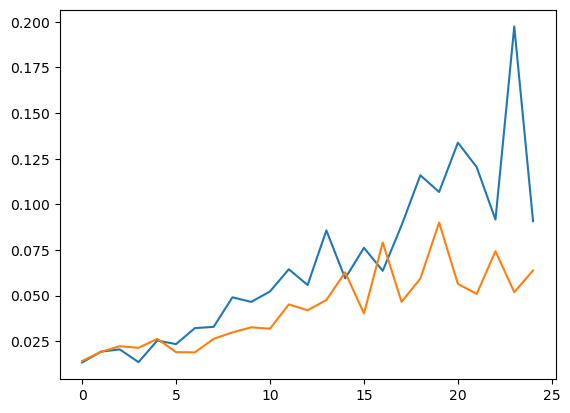

In [8]:
fig, ax = plt.subplots()
ax.plot(jpca_eig[0, 0, :, 0, 0])
ax.plot(jpca_eig[0, 0, :, 0, 1])
#fig.savefig('tmp.png')

In [26]:
jpca_eig[0, 0, :, 0, 0]

array([0.12577024, 0.13654404, 0.11379131, 0.1365949 , 0.14981208,
       0.10642807, 0.09959917, 0.10639049, 0.09071179, 0.08558685,
       0.08716043, 0.06633713, 0.07433853, 0.08041645, 0.08654922,
       0.0602669 , 0.05279587, 0.03789738, 0.02428842, 0.02033318,
       0.02494458, 0.01927813, 0.01613659, 0.01069635, 0.00725856])

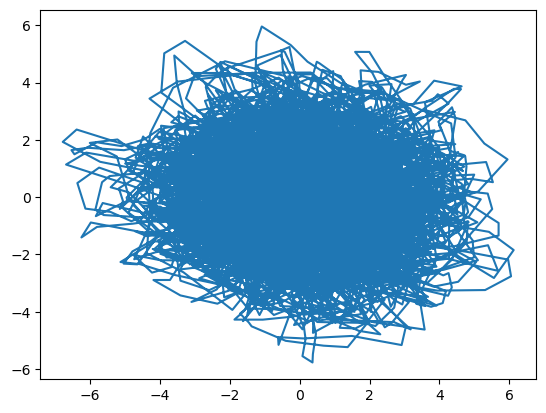

In [12]:
plt.plot(xpca[:, 0], xpca[:, 1])

In [17]:
jpcamodel = JPCA(n_components=6, mean_subtract=False)
jpcamodel.fit(xpca[np.newaxis, :])

In [20]:
np.sum(np.abs(jpcamodel.eigen_vals_))

0.9804527197245242

In [23]:
jpca_eig[0, ..., 0, :]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [1]:
# Consolidate run that was done on NERSC and plot

In [7]:
from glob import glob
import pickle
from pickle import UnpicklingError
import pandas as pd
import pdb

In [8]:
fls = glob('/mnt/Secondary/data/soc_jpca2/*.pkl')

In [9]:
rl = []
    
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                task = pickle.load(f)
                A = pickle.load(f)
                phi = pickle.load(f)
                scores = pickle.load(f)
                nn = pickle.load(f)
                jpca_eig = pickle.load(f)
                coef_ = pickle.load(f)
                Upca = pickle.load(f)

                rep, inner_rep, R = task
                r = {}
                r['rep'] = int(rep)
                r['irep'] = int(inner_rep)
                r['R'] = R
                r['A'] = A
                r['phi'] = phi
                r['scores'] = scores
                r['nn'] = nn
                r['jpca_eig'] = jpca_eig
                r['Ulqg'] = coef_
                r['Upca'] = coef_
                rl.append(r)
            except (EOFError, UnpicklingError):
                break

In [10]:
# verify a few basic dimensionalities
df = pd.DataFrame(rl)

In [11]:
# Control that uses random projections:
fls = glob('/mnt/Secondary/data/soc_jpca_control_calcs/*.pkl')
rl = []
    
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                task = pickle.load(f)
                A = pickle.load(f)
                nn = pickle.load(f)
                jpca_eig = pickle.load(f)
                rep, inner_rep, R = task
                r = {}
                r['rep'] = int(rep)
                r['irep'] = int(inner_rep)
                r['R'] = R
                r['A'] = A
                r['jpca_eig'] = jpca_eig
                rl.append(r)
            except (EOFError, UnpicklingError):
                break

In [12]:
df_control = pd.DataFrame(rl)

In [13]:
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['irep'].values)

In [14]:
# Plot curve witha
# average over reps. inner rep
jpca_eig = np.zeros((R.size, 2, 200))

jpca_eig_control = np.zeros((R.size,2000))

nn = np.zeros(R.size)
ngood = np.zeros(R.size)
for i, r in enumerate(R):
    df_ = apply_df_filters(df, R=r)
    nn[i] = df_.iloc[0]['nn']
    print(df_.shape[0])
    ngood[i] = df_.shape[0]
    for j in range(df_.shape[0]):
        jpca_eig[i, :, j] = df_.iloc[j]['jpca_eig']
        
    # If we didn't complete the run, fill in with nans
    if j < 199:
        jpca_eig[i, :, j:] = np.nan

    df_control_ = apply_df_filters(df_control, R=r)
    print(df_control_.shape[0])
    for j in range(df_control_.shape[0]):
        jpca_eig_control[i, j] = df_control_.iloc[j]['jpca_eig']
    
    # If we didn't complete the run, fill in with nans
    if j < 1999:
        jpca_eig_control[i, j:] = np.nan


200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
170
1700
160
1900
150
1900


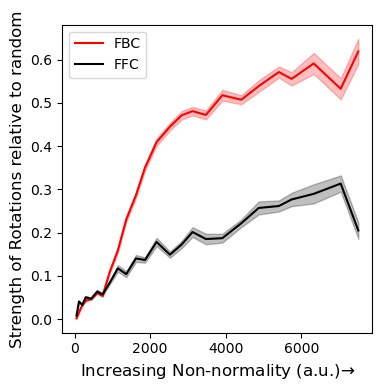

In [15]:
fig, ax =  plt.subplots(figsize=(4, 4))

# Z-score relative to random
baseline = np.nanmean(jpca_eig_control, axis=-1)[:, np.newaxis]
sigma = np.nanstd(jpca_eig_control, axis=-1)[:, np.newaxis]
jpca_eig[:, 0, :] = jpca_eig[:, 0, :] - baseline
jpca_eig[:, 1, :] = jpca_eig[:, 1, :] - baseline


ax.plot(nn, np.nanmean(jpca_eig[:, 0], axis=-1), color='r')
ax.fill_between(nn, np.nanmean(jpca_eig[:, 0], axis=-1) - 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 0], axis=-1), np.nanmean(jpca_eig[:, 0], axis=-1) + 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 0], axis=-1),
                color='r', alpha=0.25)
ax.plot(nn, np.nanmean(jpca_eig[:, 1], axis=-1), color='k')
ax.fill_between(nn, np.nanmean(jpca_eig[:, 1], axis=-1) - 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 1], axis=-1), np.nanmean(jpca_eig[:, 1], axis=-1) + 1/np.sqrt(200)*np.nanstd(jpca_eig[:, 1], axis=-1),
                color='k', alpha=0.25)
ax.set_ylabel('Strength of Rotations relative to random', fontsize=12)
# ax.plot(nn, np.nanmean(jpca_eig_control, axis=-1), color='b')
# ax.fill_between(nn, np.nanmean(jpca_eig_control, axis=-1) - 1/np.sqrt(200)*np.nanstd(jpca_eig_control, axis=-1), 
#                 np.nanmean(jpca_eig_control, axis=-1) + 1/np.sqrt(200)*np.nanstd(jpca_eig_control, axis=-1),
#                 color='b', alpha=0.25)

#ax.set_xlabel('Non-normality (a.u.)', fontsize=12)
ax.legend(['FBC', 'FFC'])
# ax.set_xticks()
ax.set_xlabel('Increasing Non-normality (a.u.)' + r'$\to$', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/synth/soc_jpca_wcontrol_zscored.pdf', bbox_inches='tight', pad_inches=0)

In [18]:
def gen_activity(A, T, h):

    # f
    def f_(x, t):
        return A @ x

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return 0.25*np.eye(A.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    
    x0 = np.ones(A.shape[0])

    return sdeint.itoSRI2(f_, g_, x0, tspace)    

In [22]:
# Plot trajectories from the systems towards the end of the curves
R = np.unique(df['R'].values)
# Get the A matrix associated with the 
df_ = apply_df_filters(df, R=R[20])
A = df_.iloc[0]['A']
d = 6
dt = 1

#X = [gen_activity(A, 100, 1e-2) for _ in range(25)]
Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
t_ = [j * dt for j in range(10)]
cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

cross_covs = torch.tensor(cross_covs)
cross_covs_rev = torch.tensor(cross_covs_rev)

e, Upca = np.linalg.eig(cross_covs[0])
eigorder = np.argsort(e)[::-1]
Upca = Upca[:, eigorder][:, 0:d]

lqgmodel = LQGCA(d=d, T=4, rng_or_seed=0)
lqgmodel.cross_covs = cross_covs
lqgmodel.cross_covs_rev = cross_covs_rev
# Simulate from the model, apply projection, and then fit jPCA

coef_, score = lqgmodel._fit_projection()

xfca = [x @ coef_ for x in X]
xpca = [x @ Upca for x in X]

/tmp/ipykernel_1972/3822844229.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)


In [18]:
from scipy.ndimage import gaussian_filter1d

In [19]:
from dca.methods_comparison import JPCA

In [20]:
# with open('soc_trajectories_tmp.dat', 'wb') as f:
#     f.write(pickle.dumps(X))
with open('soc_trajectories_tmp.dat', 'rb') as f:
    X = pickle.load(f)

In [ ]:
# Are the relative dynamic ranges preserved under variations of basis where we constrain the condition number of the basis to be
# the same in both cases?


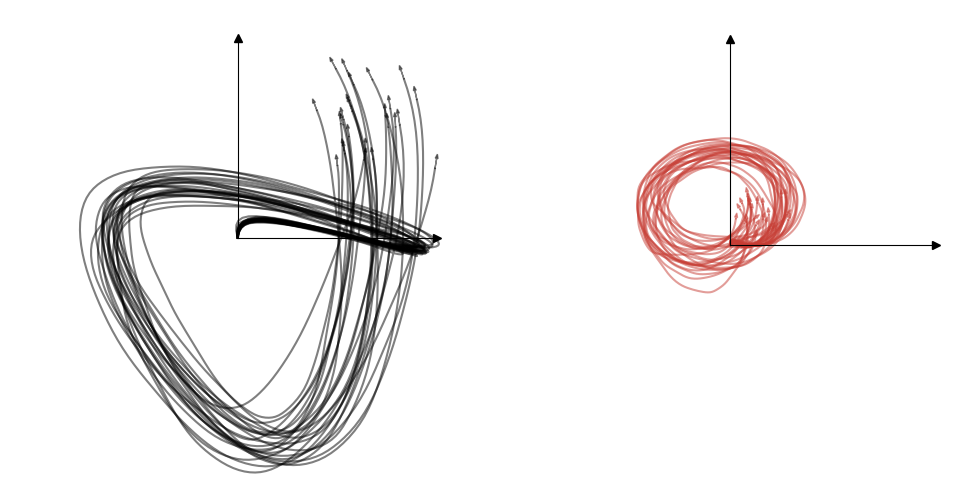

In [33]:
############## Trajectory Plots #################
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(0, 25):
    

    trajectory = xpca[i]
    trajectory = gaussian_filter1d(trajectory, sigma=2, axis=0)
    jpca = JPCA(n_components=d, mean_subtract=False)
    trajectory = jpca.fit_transform(trajectory[np.newaxis, :]).squeeze()[0:150]
    
    # Center and normalize trajectories
    trajectory -= trajectory[0]
    #trajectory /= np.linalg.norm(trajectory)

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    theta0 = np.arctan2(trajectory[15, 1], trajectory[15, 0])

    # Rotate *clockwise* by theta
    R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
    trajectory = np.array([R(theta0) @ t[0:2] for t in trajectory])

    ax[0].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
    ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=0.1, color="k", alpha=0.5)
    
    
    trajectory = xfca[i]
    trajectory = gaussian_filter1d(trajectory, sigma=2, axis=0)
    jpca = JPCA(n_components=d, mean_subtract=False)
    trajectory = jpca.fit_transform(trajectory[np.newaxis, :]).squeeze()[0:150]

    # Center trajectories
    trajectory -= trajectory[0]
    #trajectory /= np.linalg.norm(trajectory)

    # Rotate trajectory so that the first 5 timesteps all go off at the same angle
    theta0 = np.arctan2(trajectory[15, 1], trajectory[15, 0])

    trajectory = np.array([R(theta0) @ t[0:2] for t in trajectory])

    ax[1].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
    ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                head_width=0.1, color="#c73d34", alpha=0.5)

    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    
    # ax[1].set_xticklabels([])
    # ax[1].set_yticklabels([])
    
ax[0].set_xlim([-8, 8])
ax[1].set_xlim([-8, 8])

ax[0].set_ylim([-8.5, 8])
ax[1].set_ylim([-8, 8])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

#ax[0].set_title('jPCA on FFC', fontsize=14)
#ax[0].set_ylabel('jPC2', fontsize=14)
#ax[0].set_xlabel('jPC1', fontsize=14)

#ax[1].set_title('jPCA on FBC', fontsize=14)
#ax[1].set_ylabel('jPC2', fontsize=14)
#ax[1].set_xlabel('jPC1', fontsize=14)

ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')
ax[0].spines['left'].set_position('zero')
ax[0].spines['bottom'].set_position('zero')
ax[0].plot(7, 0, ">k", clip_on=False)
ax[0].plot(0, 7, "^k", clip_on=False)
ax[0].spines['left'].set_bounds(0, 7)
ax[0].spines['bottom'].set_bounds(0, 7)
# ax[0].spines['left'].set_color('none')
# ax[0].spines['bottom'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')
ax[1].spines['left'].set_position('zero')
ax[1].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_bounds(0, 7)
ax[1].spines['bottom'].set_bounds(0, 7)
ax[1].plot(7, 0, ">k", clip_on=False)
ax[1].plot(0, 7, "^k", clip_on=False)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/trajectories.pdf', bbox_inches='tight', pad_inches=0)

### Revised run with dynamic range calculated

In [7]:
fls = glob('/mnt/Secondary/data/soc_jpca_dynrange/*.pkl')

In [8]:
rl = []
    
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                task = pickle.load(f)
                A = pickle.load(f)
                phi = pickle.load(f)
                scores = pickle.load(f)
                nn = pickle.load(f)
                jpca_eig = pickle.load(f)
                coef_ = pickle.load(f)
                Upca = pickle.load(f)
                dyn_range = pickle.load(f)

                rep, inner_rep, R = task
                r = {}
                r['rep'] = int(rep)
                r['irep'] = int(inner_rep)
                r['R'] = R
                r['A'] = A
                r['phi'] = phi
                r['scores'] = scores
                r['nn'] = nn
                r['jpca_eig'] = jpca_eig
                r['Ulqg'] = coef_
                r['Upca'] = coef_
                r['dyn_range'] = dyn_range
                rl.append(r)
            except (EOFError, UnpicklingError):
                break

In [9]:
df = pd.DataFrame(rl)

In [10]:
# Control that uses random projections:
fls = glob('/mnt/Secondary/data/soc_jpca_control/*.pkl')
rl = []
    
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                task = pickle.load(f)
                A = pickle.load(f)
                nn = pickle.load(f)
                jpca_eig = pickle.load(f)
                dyn_range = pickle.load(f)
                rep, inner_rep, R = task
                r = {}
                r['rep'] = int(rep)
                r['irep'] = int(inner_rep)
                r['R'] = R
                r['A'] = A
                r['jpca_eig'] = jpca_eig
                r['dyn_range'] = dyn_range
                rl.append(r)
            except (EOFError, UnpicklingError):
                break

In [11]:
df_control = pd.DataFrame(rl)

In [12]:
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['irep'].values)

In [17]:
R

array([ 0.75      ,  1.13541667,  1.52083333,  1.90625   ,  2.29166667,
        2.67708333,  3.0625    ,  3.44791667,  3.83333333,  4.21875   ,
        4.60416667,  4.98958333,  5.375     ,  5.76041667,  6.14583333,
        6.53125   ,  6.91666667,  7.30208333,  7.6875    ,  8.07291667,
        8.45833333,  8.84375   ,  9.22916667,  9.61458333, 10.        ])

In [18]:
np.unique(df_control['R'].values)

array([ 0.75      ,  1.13541667,  1.52083333,  1.90625   ,  2.29166667,
        2.67708333,  3.0625    ,  3.44791667,  3.83333333,  4.21875   ,
        4.60416667,  4.98958333,  5.375     ,  5.76041667,  6.14583333,
        6.53125   ,  6.91666667,  7.30208333,  7.6875    ,  8.07291667,
        8.45833333,  8.84375   ,  9.22916667,  9.61458333, 10.        ])

In [29]:
# Plot curve witha
# average over reps. inner rep
jpca_eig = np.zeros((R.size, 2, 200))
jpca_eig_control = np.zeros((R.size,2000))
dyn_range = np.zeros((R.size, 2, 200))
dyn_range_control = np.zeros((R.size, 2000))

nn = np.zeros(R.size)
ngood = np.zeros(R.size)
for i, r in enumerate(R):
    df_ = apply_df_filters(df, R=r)
    nn[i] = df_.iloc[0]['nn']
    print(df_.shape[0])
    ngood[i] = df_.shape[0]
    for j in range(df_.shape[0]):
        jpca_eig[i, :, j] = df_.iloc[j]['jpca_eig']
        dyn_range[i, :, j] = df_.iloc[j]['dyn_range']
    
    # If we didn't complete the run, fill in with nans
    if j < 199:
        jpca_eig[i, :, j:] = np.nan
        dyn_range[i, :, j:] = np.nan

    df_control_ = apply_df_filters(df_control, R=r)
    print(df_control_.shape[0])
    for j in range(min(df_control_.shape[0], 2000)):
        dyn_range_control[i, j] = df_control_.iloc[j]['dyn_range']
    
    # If we didn't complete the run, fill in with nans
    if j < 1999:
        dyn_range_control[i, j:] = np.nan

200
2012
200
2011
200
2011
200
2011
200
2011
200
2011
200
2011
200
2010
200
2007
200
2005
200
2003
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
200
2000
170
1700
160
1900
150
1900


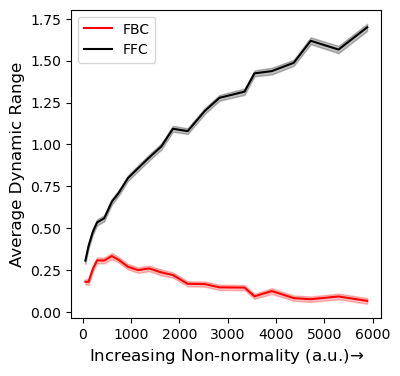

In [30]:
fig, ax =  plt.subplots(figsize=(4, 4))
cutoff = 3

baseline = np.nanmean(dyn_range_control, axis=-1)[:, np.newaxis]
dyn_range[:, 0, :] = dyn_range[:, 0, :] - baseline
dyn_range[:, 1, :] = dyn_range[:, 1, :] - baseline

ax.plot(nn[:-cutoff], np.nanmean(dyn_range[:-cutoff, 0], axis=-1), color='r')
ax.fill_between(nn[:-cutoff], np.nanmean(dyn_range[:-cutoff, 0], axis=-1) - 1/np.sqrt(200)*np.nanstd(dyn_range[:-cutoff, 0], axis=-1), 
                np.nanmean(dyn_range[:-cutoff, 0], axis=-1) + 1/np.sqrt(200)*np.nanstd(dyn_range[:-cutoff, 0], axis=-1),
                color='r', alpha=0.25)
ax.plot(nn[:-cutoff], np.nanmean(dyn_range[:-cutoff, 1], axis=-1), color='k')
ax.fill_between(nn[:-cutoff], np.nanmean(dyn_range[:-cutoff, 1], axis=-1) - 1/np.sqrt(200)*np.nanstd(dyn_range[:-cutoff, 1], axis=-1), 
                np.nanmean(dyn_range[:-cutoff, 1], axis=-1) + 1/np.sqrt(200)*np.nanstd(dyn_range[:-cutoff, 1], axis=-1),
                color='k', alpha=0.25)

ax.set_ylabel('Average Dynamic Range', fontsize=12)
# ax.plot(nn[:-cutoff], np.nanmean(dyn_range_control[:-cutoff], axis=-1), color='b')
# ax.fill_between(nn[:-cutoff], np.nanmean(dyn_range_control[:-cutoff], axis=-1) - 1/np.sqrt(200)*np.nanstd(dyn_range_control[:-cutoff], axis=-1), 
#                 np.nanmean(dyn_range_control[:-cutoff], axis=-1) + 1/np.sqrt(200)*np.nanstd(dyn_range_control[:-cutoff], axis=-1),
#                 color='b', alpha=0.25)
#ax.set_xlabel('Non-normality (a.u.)', fontsize=12)
ax.legend(['FBC', 'FFC'])
# ax.set_xticks()
ax.set_xlabel('Increasing Non-normality (a.u.)' + r'$\to$', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/synth/soc_jpca_dyn_range.pdf', bbox_inches='tight', pad_inches=0)

In [31]:
# Plots for visualizing dynamic range

In [11]:
with open('soc_trajectories_tmp.dat', 'rb') as f:
    X = pickle.load(f)

In [17]:
# Plot trajectories from the systems towards the end of the curves
R = np.unique(df['R'].values)
# Get the A matrix associated with the 
df_ = apply_df_filters(df, R=R[20])
A = df_.iloc[0]['A']
d = 6
dt = 1

#X = [gen_activity(A, 100, 1e-2) for _ in range(25)]
Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
t_ = [j * dt for j in range(10)]
cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

cross_covs = torch.tensor(cross_covs)
cross_covs_rev = torch.tensor(cross_covs_rev)

e, Upca = np.linalg.eig(cross_covs[0])
eigorder = np.argsort(e)[::-1]
Upca = Upca[:, eigorder][:, 0:d]

lqgmodel = LQGCA(d=d, T=4, rng_or_seed=0)
lqgmodel.cross_covs = cross_covs
lqgmodel.cross_covs_rev = cross_covs_rev
# Simulate from the model, apply projection, and then fit jPCA

coef_, score = lqgmodel._fit_projection()

xfca = [x @ coef_ for x in X]
xpca = [x @ Upca for x in X]

/tmp/ipykernel_12937/3822844229.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  cross_covs = torch.tensor(cross_covs)


In [18]:
from scipy.ndimage import gaussian_filter1d

In [45]:
reps = 100
fca_median_dynrange = np.zeros(reps)
pca_median_dynrange = np.zeros(reps)
for ii in tqdm(range(reps)):
    T = np.random.normal(size=(6, 6))

    # Plot trajectories from the systems towards the end of the curves
    R = np.unique(df['R'].values)
    # Get the A matrix associated with the 
    df_ = apply_df_filters(df, R=R[20])
    A = df_.iloc[0]['A']
    d = 6
    dt = 1

    #X = [gen_activity(A, 100, 1e-2) for _ in range(25)]
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))
    t_ = [j * dt for j in range(10)]
    cross_covs = [scipy.linalg.expm(tau * A) @ Pi for tau in t_]

    cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

    cross_covs = torch.tensor(cross_covs)
    cross_covs_rev = torch.tensor(cross_covs_rev)

    e, Upca = np.linalg.eig(cross_covs[0])
    eigorder = np.argsort(e)[::-1]
    Upca = Upca[:, eigorder][:, 0:d]

    lqgmodel = LQGCA(d=d, T=4, rng_or_seed=0)
    lqgmodel.cross_covs = cross_covs
    lqgmodel.cross_covs_rev = cross_covs_rev
    # Simulate from the model, apply projection, and then fit jPCA

    coef_, score = lqgmodel._fit_projection()

    xfca = [x @ coef_ for x in X]
    xpca = [x @ Upca for x in X]

    dyn_range_fca = []
    dyn_range_pca = []
    for x in xfca:
        x = x[0:250, :]
        dY = np.concatenate(np.diff(x, axis=1), axis=0)
        Y_prestate = np.concatenate(x[:, :-1], axis=0)

        # Least squares
        A, _, _, _ = np.linalg.lstsq(Y_prestate, dY, rcond=None)

        # Identify the directions in which there is the most amplification over multiple timesteps
        # Project the data along those directions and also record the amplification implied by the model

        # Iterate the lyapunov equation for 10 timesteps
        P = np.zeros((6, 6))
        for _ in range(25):
            dP = A @ P + P @ A.T + np.eye(6)
            P += dP

        eig, U = np.linalg.eig(P)
        # eig, U = np.linalg.eig(scipy.linalg.expm(A.T) @ scipy.linalg.expm(A))
        eig = np.sort(eig)[::-1]
        U = U[:, np.argsort(eig)[::-1]]
        U = U[:, 0:2]

        x -= x[0:1]

        trajectory = gaussian_filter1d(x, sigma=5, axis=1)
        dyn_range0 = np.max(np.abs(trajectory), axis=0)

        xT = x @ T
        trajectory = gaussian_filter1d(xT, sigma=5, axis=1)
        dyn_range1 = np.max(np.abs(trajectory), axis=0)
        
        dyn_range_fca.append([dyn_range0, dyn_range1])

    for x in xpca:
        x = x[0:250, :]
        x -= x[0:1]
        trajectory = gaussian_filter1d(x, sigma=5, axis=1)
        dyn_range0 = np.max(np.abs(trajectory), axis=0)

        xT = x @ T
        trajectory = gaussian_filter1d(xT, sigma=5, axis=1)
        dyn_range1 = np.max(np.abs(trajectory), axis=0)
        
        dyn_range_pca.append([dyn_range0, dyn_range1])

    dyn_range_fca = np.array(dyn_range_fca)
    dyn_range_pca = np.array(dyn_range_pca)

    fca_median_dynrange[ii] = np.median(dyn_range_fca[:, 1, :].ravel())
    pca_median_dynrange[ii] = np.median(dyn_range_pca[:, 1, :].ravel())


100%|██████████| 1000/1000 [12:37<00:00,  1.32it/s]


(array([ 14., 124., 303., 249., 167.,  87.,  34.,  13.,   4.,   5.]),
 array([0.21726245, 1.11501954, 2.01277663, 2.91053372, 3.8082908 ,
        4.70604789, 5.60380498, 6.50156207, 7.39931916, 8.29707625,
        9.19483334]),
 <BarContainer object of 10 artists>)

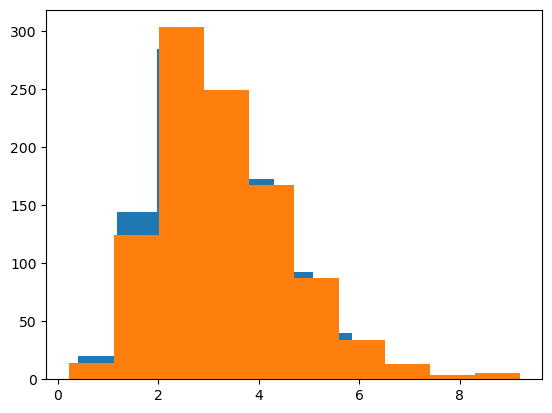

In [46]:
plt.hist(fca_median_dynrange)
plt.hist(pca_median_dynrange)

In [47]:
x = np.random.normal(size=(6,))
y = np.random.normal(size=(6,), scale=2)

In [51]:
xnorm = []
ynorm = []
reps = 1000
for _ in range(reps):
    T = np.random.normal(size=(6, 6))
    xnorm.append(np.linalg.norm(T @ x))
    ynorm.append(np.linalg.norm(T @ y))

In [53]:
np.max([xn - yn for xn, yn in zip(xnorm, ynorm)])

1.3010204788124544

(array([  4.,  11.,  26.,  88., 146., 235., 219., 156.,  81.,  34.]),
 array([-14.30897579, -12.74797616, -11.18697654,  -9.62597691,
         -8.06497728,  -6.50397766,  -4.94297803,  -3.3819784 ,
         -1.82097878,  -0.25997915,   1.30102048]),
 <BarContainer object of 10 artists>)

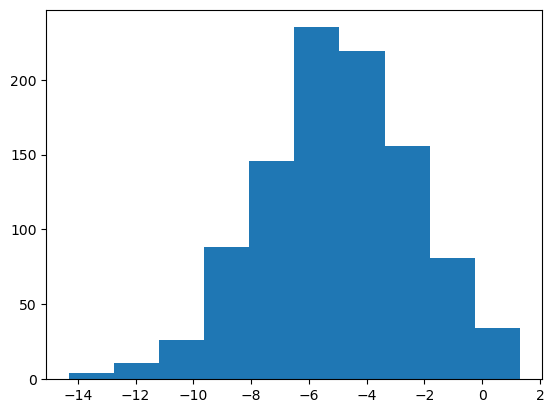

In [52]:
plt.hist([xn - yn for xn, yn in zip(xnorm, ynorm)])

(array([ 7., 15., 19., 18., 25., 17., 18., 19.,  8.,  4.]),
 array([0.88640773, 0.91074712, 0.93508652, 0.95942592, 0.98376531,
        1.00810471, 1.03244411, 1.0567835 , 1.0811229 , 1.1054623 ,
        1.12980169]),
 <BarContainer object of 10 artists>)

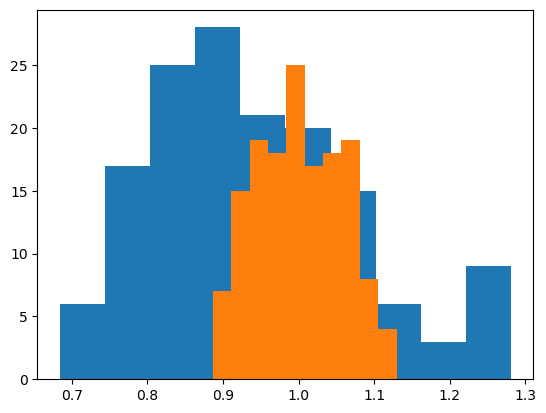

In [43]:
plt.hist(dyn_range_fca[:, 0, :].ravel())
plt.hist(dyn_range_pca[:, 0, :].ravel())

(array([ 6., 13., 12., 23., 27., 21., 16., 19.,  8.,  5.]),
 array([3.13640539, 3.17576002, 3.21511465, 3.25446928, 3.29382391,
        3.33317853, 3.37253316, 3.41188779, 3.45124242, 3.49059704,
        3.52995167]),
 <BarContainer object of 10 artists>)

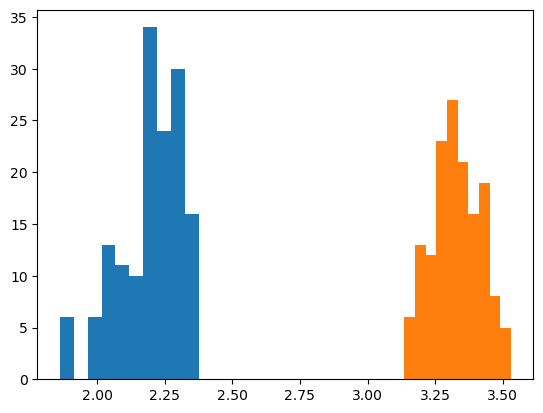

In [44]:
plt.hist(dyn_range_fca[:, 1, :].ravel())
plt.hist(dyn_range_pca[:, 1, :].ravel())

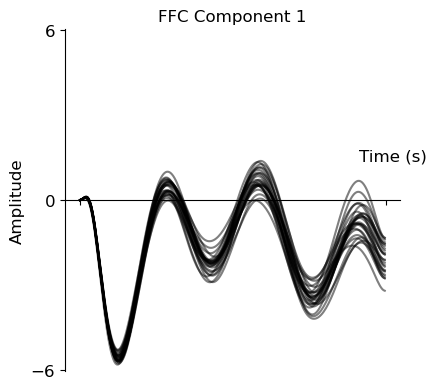

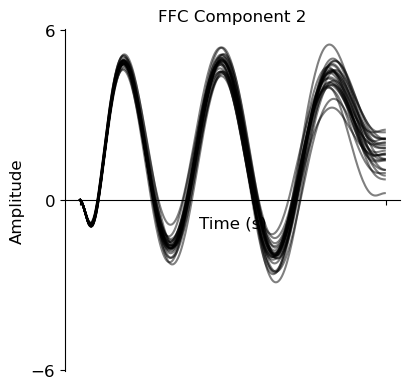

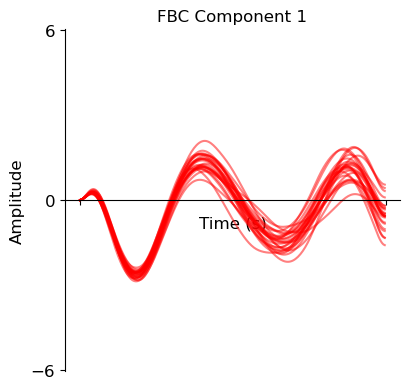

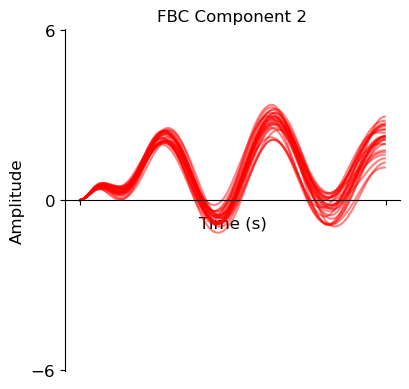

In [67]:
colors = ['k', 'r']
DIM = 6
T = 250
dimreduc_method = ['PCA', 'LQGCA']
for j, yproj in enumerate([xpca, xfca]):
    yproj = np.array([y_[0:T] for y_ in yproj])
    yproj = np.array([y_ - y_[0] for y_ in yproj])

    dY = np.concatenate(np.diff(yproj, axis=1), axis=0)
    Y_prestate = np.concatenate(yproj[:, :-1], axis=0)

    # Least squares
    A, _, _, _ = np.linalg.lstsq(Y_prestate, dY, rcond=None)

    # Identify the directions in which there is the most amplification over multiple timesteps
    # Project the data along those directions and also record the amplification implied by the model

    # Iterate the lyapunov equation for 10 timesteps
    P = np.zeros((DIM, DIM))
    for _ in range(10):
        dP = A @ P + P @ A.T + np.eye(DIM)
        P += dP

    eig, U = np.linalg.eig(P)
    # eig, U = np.linalg.eig(scipy.linalg.expm(A.T) @ scipy.linalg.expm(A))
    eig = np.sort(eig)[::-1]
    U = U[:, np.argsort(eig)[::-1]]
    U = U[:, 0:2]
    # Plot smoothed, centered trajectories for all reaches in top 2 dimensions

    # Argsort by the maximum amplitude in the top 2 dimensions
    trajectory = gaussian_filter1d(yproj, sigma=5, axis=1)
    trajectory -= trajectory[:, 0:1, :]
    trajectory = trajectory @ U
    dyn_range = np.max(np.abs(trajectory), axis=1)
    ordering = np.argsort(dyn_range, axis=0)[::-1]

    t0 = trajectory[ordering[:, 0], :, 0]
    t1 = trajectory[ordering[:, 1], :, 1]

    f1, a1 = plt.subplots(1, 1, figsize=(4.2, 4))
    f2, a2 = plt.subplots(1, 1, figsize=(4.2, 4))
    ax = [a1, a2]

    for i in range(25):
        ax[0].plot(np.arange(T), t0[i], color=colors[j], alpha=0.5, linewidth=1.5)
        ax[1].plot(np.arange(T), t1[i], color=colors[j], alpha=0.5, linewidth=1.5)
        #ax[2*j].set_title(np.sum(eig))
        
    for k, a in enumerate(ax):
        a.spines['bottom'].set_position('center')
        # Eliminate upper and right axes
        a.spines['right'].set_color('none')
        a.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        a.xaxis.set_ticks_position('bottom')
        a.yaxis.set_ticks_position('left')

        a.set_xticks([0, T])
        a.set_xticklabels([])
        a.tick_params(axis='both', labelsize=12)
        a.set_xlabel('Time (s)', fontsize=12)
        if j == 0 and k == 0:
            a.xaxis.set_label_coords(0.98, 0.65)
        else:
            a.xaxis.set_label_coords(0.98, 0.35)
        
    # Set y scale according to the current yscale on PCA 0
    if j == 0:
        ylim_max = np.max(np.abs(t0[1])) + 0.25
        ylim = [-ylim_max, ylim_max]

    for a in ax:
        a.set_ylim(ylim)
        a.set_yticks([-int(ylim_max), 0, int(ylim_max)])
        a.set_ylabel('Amplitude', fontsize=12)

    if j == 0:
        ax[0].set_title('FFC Component 1', fontsize=12)
        ax[1].set_title('FFC Component 2', fontsize=12)
    else:
        ax[0].set_title('FBC Component 1', fontsize=12)
        ax[1].set_title('FBC Component 2', fontsize=12)

    f1.tight_layout()
    f2.tight_layout()
    f1.savefig('/home/akumar/nse/neural_control/figs/amplification/soc_%s1.pdf' % dimreduc_method[j], bbox_inches='tight', pad_inches=0)
    f2.savefig('/home/akumar/nse/neural_control/figs/amplification/soc_%s2.pdf' % dimreduc_method[j], bbox_inches='tight', pad_inches=0)


### Poisson Emission Process

In [6]:
from soc_jpca_mpi import gen_activity
from dca.cov_util import calc_cross_cov_mats_from_data

In [7]:
with open('/home/akumar/nse/neural_control/soc_jpca_Atmp.pkl', 'rb') as f:
    Alist = pickle.load(f)

In [9]:
A = Alist[0][0]

In [10]:
x = gen_activity(1, A, lambda x: x, 1, 1000, 1e-1)

In [11]:
ccm1 = calc_cross_cov_mats_from_data(x, 5)

In [36]:
boxcox = 0.5
log0 = lambda x: np.log(x, where=x > 0, out=np.zeros_like(x.astype(float)))
spike_rates_trials = []
for _ in tqdm(range(500)):
    spike_counts = np.random.poisson(np.exp(x))
    spike_rates = np.array([(np.power(spike_count, boxcox) - 1)/boxcox 
                              for spike_count in spike_counts])
    # spike_rates = np.array([log0(spike_count) 
    #                           for spike_count in spike_counts])
    # spike_rates = np.array([scipy.stats.boxcox(spike_count, boxcox) for spike_count in spike_counts])
    spike_rates_trials.append(spike_rates)
spike_rates_trials = np.array(spike_rates_trials)
ccm2 = calc_cross_cov_mats_from_data(spike_rates_trials, 5)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:03<00:00,  7.86it/s]


In [37]:
# What is the pearson correlation?
pr = np.array([[scipy.stats.pearsonr(ccm1[:, i, j], ccm2[:, i, j])[0] for j in range(ccm1.shape[2])]
                for i in range(ccm1.shape[1])])

(array([   74.,   164.,   190.,   321.,   425.,   617.,   941.,  1647.,
         3696., 31925.]),
 array([-0.98990097, -0.79091192, -0.59192287, -0.39293382, -0.19394477,
         0.00504428,  0.20403332,  0.40302237,  0.60201142,  0.80100047,
         0.99998952]),
 <BarContainer object of 10 artists>)

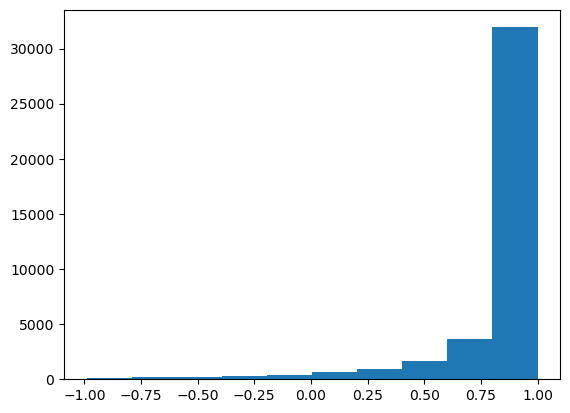

In [38]:
plt.hist(pr.ravel())

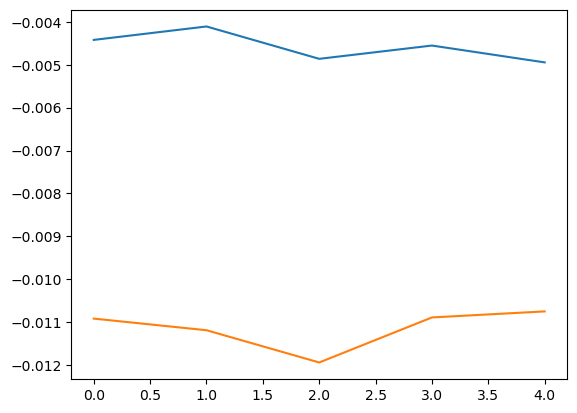

In [39]:
plt.plot(ccm1[:, 1, 2])
plt.plot(ccm2[:, 1, 2])

In [ ]:
# Can we get the autocorrelation matrices obtained from the boxcox transformed variables 
# to match the autocorrelation matrices of the original x?

### Stationary case

In [6]:
rl = []
fls = glob('/mnt/Secondary/data/soc_scov_all_d2/*.pkl')

In [7]:
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                task = pickle.load(f)
                nn = pickle.load(f)
                Upca = pickle.load(f)
                coef = pickle.load(f)
                phi = pickle.load(f)
                scores = pickle.load(f)

                rep, inner_rep, r = task
                rep = int(rep)
                inner_rep = int(inner_rep)

                rd = {}
                rd['R'] = r
                rd['nn'] = nn
                rd['rep'] = rep
                rd['inner_rep'] = inner_rep
                rd['phi'] = phi
                rl.append(rd)
            except EOFError:
                break

In [8]:
df = pd.DataFrame(rl)

In [10]:
# Truncate R and save away the dataframe
R = np.unique(df['R'].values)

In [12]:
Rtrunc = R[0:20]

In [16]:
df_trunc = df[df['R'].isin(Rtrunc)]

In [17]:
with open('/home/akumar/nse/fcca_neurips/soc_df.pkl', 'wb') as f:
    f.write(pickle.dumps(df_trunc))

In [9]:
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['inner_rep'].values)

# Need to re-run keeping track of T
ssa = np.zeros((R.size, reps.size, inner_reps.size))
nn = np.zeros((R.size, reps.size, inner_reps.size))
for i, r in enumerate(R):
    for j, rep in enumerate(reps):
        for k, irep in enumerate(inner_reps):
            df_ = apply_df_filters(df, R=r, rep = rep, inner_rep=irep)    
            assert(df_.shape[0] == 1)
            ssa[i, j, k] = df_.iloc[0]['phi']
            nn[i, j, k] = df_.iloc[0]['nn']

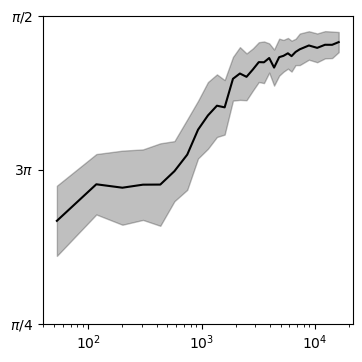

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.nanmean(nn, axis=(1, 2)), np.nanmean(ssa[...], axis=(1, 2)), color='k', linestyle='-')
ax.fill_between(np.nanmean(nn, axis=(1, 2)), 
                np.nanmean(ssa[...], axis=(1, 2)) + np.nanstd(ssa[...], axis=(1, 2)),
                np.nanmean(ssa[...], axis=(1, 2)) - np.nanstd(ssa[...], axis=(1, 2)),
                alpha=0.25, color='k')
ax.set_ylim([np.pi/4, np.pi/2])
ax.set_yticks([np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_yticklabels([r'$\pi/4$', r'$3\pi`/8$', r'$\pi/2$'])
ax.set_xscale('log')
#fig.savefig('/home/akumar/nse/fcca_neurips/soc_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [18]:
rl = []
fls = glob('/mnt/Secondary/data/soc_s3/*.pkl')

In [19]:
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                elem = pickle.load(f)
                if isinstance(elem, dict):
                    rl.append(elem)
            except EOFError:
                break

In [ ]:
# Truncate R, dim and 

In [145]:
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['inner_rep'].values)

# Need to re-run keeping track of T
ssa = np.zeros((R.size, reps.size, inner_reps.size))
nn = np.zeros((R.size, reps.size, inner_reps.size))
for i, r in enumerate(R):
    for j, rep in enumerate(reps):
        for k, irep in enumerate(inner_reps):
            df_ = apply_df_filters(df, R=r, rep = rep, inner_rep=irep)    
            if df_.shape[0] == 0:
                ssa[i, j, k] = np.nan   
                nn[i, j, k] = np.nan
            else:
                nn[i, j, k] = np.mean(df_.iloc[0]['nn'])
                c1 = df_.iloc[0]['pca_coef']
                c2 = df_.iloc[0]['fcca_coef']
                ssa[i, j, k] = np.mean(scipy.linalg.subspace_angles(c1, c2))

In [149]:
np.mean(ssa, axis=(1,2))

array([1.08406933, 1.09010094, 1.0925016 , 1.08983145, 1.08983145,
       1.10880893, 1.10537648, 1.14602806, 1.14798505, 1.14798505,
       1.14153966, 1.13875702, 1.12978412, 1.14047593, 1.14047593,
       1.14047593, 1.12747217, 1.12747217, 1.09626547, 1.09626547,
       1.12694134, 1.12694134, 1.10818553, 1.10818553, 1.10818553,
       1.08121891, 1.08617124, 1.06332424, 1.05178559, 1.04718045])

In [150]:
np.mean(nn, axis=(1, 2))

array([   52.63894296,   117.16990489,   203.36018693,   309.38276791,
         437.18368882,   580.14756232,   743.80406866,   930.25074299,
        1148.86510653,  1367.95953011,  1626.85149313,  1895.59646979,
        2195.47700121,  8940.60158732,  2530.15091346,  2870.403847  ,
       10574.56104843,  3191.30165609, 12332.41033387,  3581.86798882,
       14343.49112932,  3975.46517177, 16428.82377395,  4371.3068029 ,
        4841.82268352,  5335.0689347 ,  5824.3102284 ,  6327.88990561,
        6800.77501673,  7411.08447258])

[Text(0, 0.0, '0'),
 Text(0, 0.39269908169872414, '$\\pi/8$'),
 Text(0, 0.7853981633974483, '$\\pi/4$'),
 Text(0, 1.1780972450961724, '$3\\pi`/8$'),
 Text(0, 1.5707963267948966, '$\\pi/2$')]

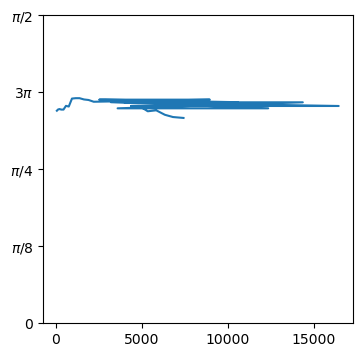

In [151]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.nanmean(nn, axis=(1, 2)), np.nanmean(ssa[...], axis=(1, 2)))
# ax.fill_between(np.nanmean(nn, axis=(1, 2)), 
#                 np.nanmean(ssa[...], axis=(1, 2)) + np.nanstd(ssa[...], axis=(1, 2)),
#                 np.nanmean(ssa[...], axis=(1, 2)) - np.nanstd(ssa[...], axis=(1, 2)),
#                 alpha=0.5)
ax.set_ylim([0, np.pi/2])
ax.set_yticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])

ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi`/8$', r'$\pi/2$'])

### Poisson fits

In [20]:
rl = []
fls = glob('/mnt/Secondary/data/soc_poisson_sdeint_dimreduc2/*.pkl')
fl2 = glob('/mnt/Secondary/data/soc_poisson_sdeint_dimreduc/*.pkl')

In [21]:
for fl in fls:
    with open(fl, 'rb') as f:
        rl_ = pickle.load(f)
    rl.extend(rl_)
for fl in fl2:
    with open(fl, 'rb') as f:
        rl_ = pickle.load(f)
    rl.extend(rl_)

In [22]:
df = pd.DataFrame(rl)

In [23]:
# Truncate R, dim and T
df_trunc = df[df['R'].isin(Rtrunc)]
df_trunc = df_trunc[df_trunc['dim'].isin([2])]
df_trunc = df_trunc[df_trunc['T'].isin([3])]

In [24]:
with open('/home/akumar/nse/fcca_neurips/soc_poisson_df.pkl', 'wb') as f:
    f.write(pickle.dumps(df_trunc))

In [15]:
dims = [2, 3, 4, 5, 6]
T = [2, 3, 4]
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['inner_rep'].values)

In [16]:
# Need to re-run keeping track of T
ssa_p = np.zeros((R.size, reps.size, inner_reps.size, len(dims), len(T)))
nn_p = np.zeros((R.size, reps.size, inner_reps.size))
for i, r in enumerate(R):
    for j, rep in enumerate(reps):
        for k, irep in enumerate(inner_reps):
            df_ = apply_df_filters(df, R=r, rep = rep, inner_rep=irep)    
            for l, dim in enumerate(dims):
                for m, t in enumerate(T):         
                    df__ = apply_df_filters(df_, dim=dim, T=t)
                    if df_.shape[0] == 0:
                        ssa_p[i, j, k, l, m] = np.nan
                        nn_p[i, j, k] = np.nan
                    else:
                        nn_p[i, j, k] = df__.iloc[0]['nn']
                        c1 = df__.iloc[0]['pca_coef']
                        c2 = df__.iloc[0]['fcca_coef']
                        ssa_p[i, j, k, l, m] = np.mean(scipy.linalg.subspace_angles(c1, c2))

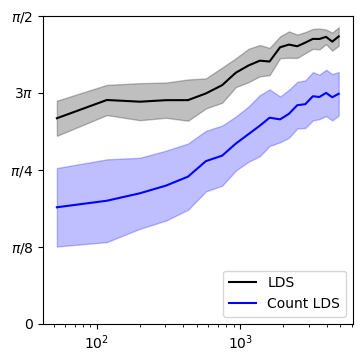

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
cutoff_idx = 20
ax.plot(np.nanmean(nn[0:cutoff_idx], axis=(1, 2)), 
        np.nanmean(ssa[0:cutoff_idx], axis=(1, 2)), color='k', linestyle='-')
ax.fill_between(np.nanmean(nn[0:cutoff_idx], axis=(1, 2)), 
                np.nanmean(ssa[0:cutoff_idx], axis=(1, 2)) + \
                    np.nanstd(ssa[0:cutoff_idx], axis=(1, 2)),
                np.nanmean(ssa[0:cutoff_idx], axis=(1, 2)) - \
                    np.nanstd(ssa[0:cutoff_idx], axis=(1, 2)),
                alpha=0.25, color='k')

ax.plot(np.nanmean(nn_p[0:cutoff_idx], axis=(1, 2)), 
        np.nanmean(ssa_p[0:cutoff_idx, ..., 0, 1], axis=(1, 2)), color='b')
# ax.plot(R, np.nanmean(ssa_p[..., 0, 1], axis=(1, 2)), color='b')
ax.fill_between(np.nanmean(nn_p[0:cutoff_idx], axis=(1, 2)), 
               np.nanmean(ssa_p[0:cutoff_idx, ..., 0, 1], axis=(1, 2)) + \
                np.nanstd(ssa_p[0:cutoff_idx, ..., 0, 1], axis=(1, 2)),
               np.nanmean(ssa_p[0:cutoff_idx, ..., 0, 1], axis=(1, 2)) - \
                np.nanstd(ssa_p[0:cutoff_idx, ..., 0, 1], axis=(1, 2)),
               alpha=0.25, color='b')
ax.set_ylim([0, np.pi/2])
ax.set_yticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi`/8$', r'$\pi/2$'])
ax.set_xscale('log')
ax.legend(['LDS', 'Count LDS'], loc='lower right')
fig.savefig('/home/akumar/nse/fcca_neurips/soc_ssa_coplot.pdf', bbox_inches='tight', pad_inches=0)

In [70]:
# Co-plot
fig, ax = plt.subplots(figsize=(4, 4))



ax.plot(np.nanmean(nn_p, axis=(1, 2)), np.nanmean(ssa_p[..., 0, 1], axis=(1, 2)), color='b')
ax.fill_between(np.nanmean(nn_p, axis=(1, 2)), 
                np.nanmean(ssa_p[..., 0, 1], axis=(1, 2)) + np.nanstd(ssa_p[..., 0, 1], axis=(1, 2)),
                np.nanmean(ssa_p[..., 0, 1], axis=(1, 2)) - np.nanstd(ssa_p[..., 0, 1], axis=(1, 2)),
                alpha=0.25, color='b')
ax.set_ylim([0, np.pi/2])
ax.set_yticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi`/8$', r'$\pi/2$'])
ax.set_xscale('log')
#fig.savefig('/home/akumar/nse/fcca_neurips/soc_ssa_poisson.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
# Which things completed?
bad = []
for i, r in enumerate(R):
for j, rep in enumerate(reps):
        for k, irep in enumerate(inner_reps):
            df_ = apply_df_filters(df, R=r, rep = rep, inner_rep=irep)    
            if df_.shape[0] == 0:
                bad.append((r, rep, irep))

In [13]:
Rbad = [b[0] for b in bad]

In [14]:
np.unique(Rbad)

array([ 0.75      ,  1.13541667,  1.52083333,  1.90625   ,  2.29166667,
        9.22916667,  9.61458333, 10.        ])

In [26]:
sys.path.append('/home/akumar/nse/neural_control')

In [27]:
from soc_jpca_mpi_poisson import gen_activity

In [17]:
# Why does the simulation fail at higher R?
with open('/home/akumar/nse/neural_control/soc_jpca_Atmp.pkl', 'rb') as f:
    Alist = pickle.load(f)

In [18]:
A = Alist[-1][-1]

In [28]:
x = gen_activity(1, A, lambda x: x, 1, 1000, 1e-1)   

In [30]:
x

array([[-1.80364736,  0.72648239,  0.26466073, ..., -0.30050585,
        -0.54682044, -0.2321753 ],
       [-1.09678538,  0.98687833,  0.09488579, ..., -0.98946773,
        -1.15614685, -0.94140791],
       [-0.47378998,  0.59474667, -0.01196578, ..., -1.9898046 ,
        -1.91751882,  0.19763395],
       ...,
       [ 0.81569283, -0.00894263,  0.20574457, ...,  0.58436667,
         0.52503704, -0.51003538],
       [ 1.93211333,  0.32321095, -0.54403834, ...,  0.19504572,
         0.8438659 , -0.62769985],
       [ 1.76975059,  1.25650708, -0.04910558, ...,  0.05716553,
         1.26325419, -0.58646132]])

In [13]:
# Merge A lists
with open('/home/akumar/nse/neural_control/soc_jpca_Atmp.pkl', 'rb') as f:
    Alist = pickle.load(f)
with open('/home/akumar/nse/neural_control/Alistnew.pkl', 'rb') as f:
    Alistnew = pickle.load(f)

Alistconcat = []

for i in range(len(Alist)):
    Alistconcat.append([])
    Alistconcat[i].extend(Alist[i])
    Alistconcat[i].extend(Alistnew[i])

with open('/home/akumar/nse/neural_control/soc_Alist.pkl', 'wb') as f:
    f.write(pickle.dumps(Alistconcat))

### Non-stationarity

In [7]:
from soc_jpca_mpi import gen_activity
from dca.cov_util import calc_cross_cov_mats_from_data

In [8]:
with open('/home/akumar/nse/neural_control/soc_jpca_Atmp.pkl', 'rb') as f:
    Alist = pickle.load(f)

In [12]:
interp_intervals = np.linspace(0, 100, 6)

In [84]:
e = np.random.uniform(0.5, 1, size=(10,))
U = scipy.stats.ortho_group.rvs(10)

In [85]:
A = U @ np.diag(e) @ U.T

In [86]:
B = scipy.linalg.logm(A)

In [89]:
A = np.random.normal(size=(10, 10))
A = 0.5 * (A - A.T)

In [91]:
B = scipy.linalg.expm(A)

In [92]:
np.allclose(B.T, np.linalg.inv(B))

True

In [16]:
np.where((interp_intervals - 16) > 0)[0]

array([1, 2, 3, 4, 5])

In [29]:
intervals = np.linspace(0, 100, 5)

In [32]:
intervals

array([  0.,  25.,  50.,  75., 100.])

In [43]:
np.where(intervals - 0.1 < 0)[0][-1]

0

In [94]:
C = np.linspace(0, 1, 50)[:, np.newaxis, np.newaxis] * A

In [113]:
def orth_seq(Af, n):
    assert(np.allclose(Af, -1*Af.T))
    seq = np.concatenate([np.linspace(0, 1, n//2), np.linspace(0, 1, n//2)[::-1]])
    Aseq = seq[:, np.newaxis, np.newaxis] * Af
    B = scipy.linalg.expm(Aseq)
    return B

In [134]:
Af = np.random.normal(size=(200, 200))
Af = 0.5 * (Af - Af.T)
Af *= 1e-2

In [135]:
Bseq = orth_seq(Af, 50)

In [139]:
A0 = Alist[0][-1]
Aseq = [B @ A0 @ B.T for B in Bseq]

In [140]:
n1 = [np.linalg.norm(B - np.eye(200)) for B in Bseq]
n2 = [np.linalg.norm(A - A0)/np.linalg.norm(A0) for A in Aseq]

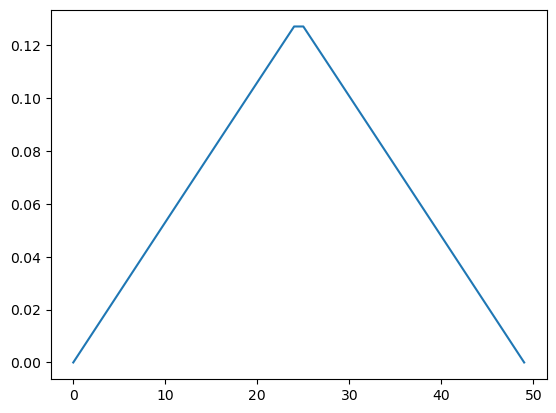

In [141]:
plt.plot(n2)

In [ ]:
# For non-stationarity, choose a sequence of A matrices
# and switch between them at uniform intervals

# Use the rep parameter to choose the sequence.
def gen_activity_ns(tau, W, Sf, sigma, T, h, key):

    # Apply a slow unitary rotation to W - this preserves spectrum and
    # non-normality
    theta_f = lambda t: t/T * np.pi/2

    def Wt(t):
        St = jnp.sin(theta_f(t)) * Sf
        Stexp = jax.scipy.expm(St)
        return Stexp @ W @ Stexp.T

In [106]:
A = np.random.normal(size=(10, 10))

In [107]:
U = scipy.stats.ortho_group.rvs(10)

In [108]:
B = U @ A @ np.linalg.inv(U)

In [109]:
np.linalg.norm(A @ A.T - A.T @ A)

31.150576185962997

In [110]:
np.linalg.norm(B @ B.T - B.T @ B)

31.15057618596302

In [12]:
rl = []
fls = glob('/mnt/Secondary/data/soc_ns_dimreduc_all/*.pkl')

In [13]:
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                elem = pickle.load(f)
                if isinstance(elem, dict):
                    rl.append(elem)
            except EOFError:
                break

In [14]:
df = pd.DataFrame(rl)

In [15]:
R = np.unique(df['R'].values)
reps = np.unique(df['rep'].values)
inner_reps = np.unique(df['inner_rep'].values)

# Need to re-run keeping track of T
ssa = np.zeros((R.size, reps.size, inner_reps.size))
nn = np.zeros((R.size, reps.size, inner_reps.size))
for i, r in enumerate(R):
    for j, rep in enumerate(reps):
        for k, irep in enumerate(inner_reps):
            df_ = apply_df_filters(df, R=r, rep = rep, inner_rep=irep)    
            if df_.shape[0] == 0:
                ssa[i, j, k] = np.nan   
                nn[i, j, k] = np.nan
            else:
                nn[i, j, k] = np.mean(df_.iloc[0]['nn'])
                c1 = df_.iloc[0]['pca_coef']
                c2 = df_.iloc[0]['fcca_coef']
                ssa[i, j, k] = np.mean(scipy.linalg.subspace_angles(c1, c2))

In [16]:
Rtrunc = R[0:20]

In [17]:
Rtrunc

array([0.75      , 1.13541667, 1.52083333, 1.90625   , 2.29166667,
       2.67708333, 3.0625    , 3.44791667, 3.83333333, 4.21875   ,
       4.60416667, 4.98958333, 5.375     , 5.76041667, 6.14583333,
       6.53125   , 6.91666667, 7.30208333, 7.6875    , 8.07291667])

In [18]:
# Save truncated dataframe
df_trunc = df[df['R'].isin(Rtrunc)]

In [20]:
with open('/home/akumar/nse/fcca_neurips/soc_ns_df.pkl', 'wb') as f:
    f.write(pickle.dumps(df_trunc))

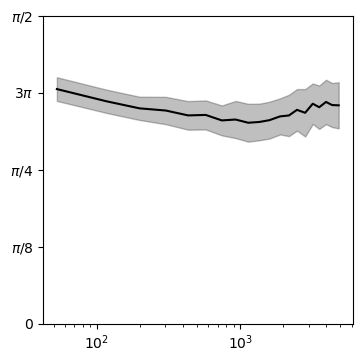

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
cutoff_idx = 20
ax.plot(np.nanmean(nn[0:cutoff_idx], axis=(1, 2)), 
        np.nanmean(ssa[0:cutoff_idx], axis=(1, 2)), color='k', linestyle='-')
ax.fill_between(np.nanmean(nn[0:cutoff_idx], axis=(1, 2)), 
                np.nanmean(ssa[0:cutoff_idx], axis=(1, 2)) + \
                    np.nanstd(ssa[0:cutoff_idx], axis=(1, 2)),
                np.nanmean(ssa[0:cutoff_idx], axis=(1, 2)) - \
                    np.nanstd(ssa[0:cutoff_idx], axis=(1, 2)),
                alpha=0.25, color='k')

ax.set_ylim([0, np.pi/2])
ax.set_yticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_yticklabels([0, r'$\pi/8$', r'$\pi/4$', r'$3\pi`/8$', r'$\pi/2$'])
ax.set_xscale('log')
fig.savefig('/home/akumar/nse/fcca_neurips/ssa_ns.pdf')

In [36]:
with open('/home/akumar/nse/neural_control/soc_Alist.pkl', 'rb') as f:
    Alist = pickle.load(f)

In [ ]:
np.block_diag([np.eye(5)])

In [37]:
W = Alist[0][0]

In [38]:
eig, U = np.linalg.eig(W)

In [42]:
eigorder = np.argsort(np.real(eig))[::-1]

In [43]:
eigorder

array([  3,   4,  24,  25,  20,  21,  51,  50,  49,  48,  66,  67,  82,
        83,  35,  34,  69,  68,  65,  64,  38,  39, 113,  91,  92, 125,
       122, 121, 115, 114,  18,  19, 134,  81,  80, 123, 124,  47,  46,
       139, 140, 152, 153, 151, 150, 103, 104, 156,   1,   2,  40,  41,
        94,  93, 135, 136, 162, 161,  33,  32,  63,  62, 178, 177, 112,
       111,  84,  85, 149, 148, 180, 179, 164, 163, 187, 186, 157, 158,
        98,  97, 182, 181,  17,  16, 141, 142,  43,  42, 196, 197, 143,
       144, 174, 173, 189, 188, 126, 127,  76,  77,  59,  58, 185, 184,
       176, 175, 198, 199, 102, 101, 170, 171, 120, 119, 194, 195,  36,
        37, 192, 193, 168, 169,  99, 100,  78,  79, 191, 190, 159, 160,
       183, 154, 155, 133, 132,  54,  55,  96,  95,  12,  13, 167, 166,
       107, 108, 172, 146, 147, 137, 138,  56,  57, 165,   7,   8,  86,
        87,  45,  44, 145,  75,  74, 128, 129,  22,  23, 131, 130, 116,
       118, 117,  71,  70,  89,  90, 106, 105, 110, 109,  27,  2

In [48]:
def Rmat(th):
    return np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])

In [49]:
S = scipy.linalg.block_diag(Rmat(np.pi/3), np.eye(W.shape[0] - 2))

In [ ]:
# Alternative generation of non-stationarity: 

# Slowly rotate the top 2 eigenbases by some angle 

def Wt(t):

    

    if np.isclose(t, 0):
        interval = 0
    else:
            interval = np.where(interp_intervals - t < 0)[0][-1]
    return Wseq[interval]


In [36]:
# What is the maximum eigenvalue that yields stable simulations?

In [38]:
M = 100
p = 0.25
    #gamma = np.array([2])
g = 2

In [28]:
import numba

In [67]:
# Pre-generate all random numbers
def rand_gen(N, m, h, generator):
    # Hard code n to 5
    n = 5
    dW = generator.normal(0.0, np.sqrt(h), (N, m))
    Xk = generator.standard_normal((n, N, m, 1))
    Yk = generator.standard_normal((n, N, m, 1))
    return dW, Xk, Yk

@numba.njit
def ito_int_(tau, W, y0, tspan, dW, Xk, Yk):
    # f
    def f(x, t):
        return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ x)

    # G: linear i.i.d noise with sigma
    def G(x, t):
        return np.eye(W.shape[0])
    
    # Embed the sdeint function directly to enable numba compilation
    def _Aterm(N, h, m, k, dW, Xk, Yk):
        """kth term in the sum of Wiktorsson2001 equation (2.2)"""
        sqrt2h = np.sqrt(2.0/h)
        term1 = np.einsum('ijk,ikl->ijl', Xk, (Yk + sqrt2h*dW).transpose((0, 2, 1)))    
        term2 = np.einsum('ijk,ikl->ijl', Yk + sqrt2h*dW, Xk.transpose((0, 2, 1)))
        return (term1 - term2)/k

    def Ikpw(dW, h, Xk, Yk):
        """matrix I approximating repeated Ito integrals for each of N time
        intervals, based on the method of Kloeden, Platen and Wright (1992).

        Args:
        dW (array of shape (N, m)): giving m independent Weiner increments for
            each time step N. (You can make this array using sdeint.deltaW())
        h (float): the time step size
        n (int, optional): how many terms to take in the series expansion
        generator (numpy.random.Generator, optional)

        Returns:
        (A, I) where
            A: array of shape (N, m, m) giving the Levy areas that were used.
            I: array of shape (N, m, m) giving an m x m matrix of repeated Ito
            integral values for each of the N time intervals.
        """
        # hard code n to 5
        n = 5

        N = dW.shape[0]
        m = dW.shape[1]
        if dW.ndim < 3:
            dW = dW.reshape((N, -1, 1)) # change to array of shape (N, m, 1)
        if dW.shape[2] != 1 or dW.ndim > 3:
            raise(ValueError)
        # Need to allocate Xk and Yk here
        A = _Aterm(N, h, m, 1, dW, Xk[0], Yk[0])
        for k in range(2, n+1):
            A += _Aterm(N, h, m, k, dW, Xk[1], Yk[1])
        A = (h/(2.0*np.pi))*A
        I = 0.5*(np.einsum('ijk,ikl->ijl', dW, dW.transpose(0, 2, 1)) - np.diag(h*np.ones(m))) + A
        dW = dW.reshape((N, -1)) # change back to shape (N, m)
        return (A, I)

    N = len(tspan)
    m = W.shape[0]
    d = W.shape[0]
    h = (tspan[N-1] - tspan[0])/(N - 1) # assuming equal time steps
    # pre-generate Wiener increments (for m independent Wiener processes):
    # pre-generate repeated stochastic integrals for each time step.
    # Must give I_ij for the Ito case or J_ij for the Stratonovich case:
    __, I = Ikpw(dW, h, Xk, Yk) # shape (N, m, m)

    # allocate space for result
    y = np.zeros((N, d), dtype=y0.dtype)
    y[0] = y0
    Gn = np.zeros((d, m), dtype=y.dtype)
    for n in range(0, N-1):
        tn = tspan[n]
        tn1 = tspan[n+1]
        h = tn1 - tn
        sqrth = np.sqrt(h)
        Yn = y[n] # shape (d,)
        Ik = dW[n,:] # shape (m,)
        Iij = I[n,:,:] # shape (m, m)
        fnh = f(Yn, tn)*h # shape (d,)
        Gn = G(Yn, tn)
        sum1 = np.dot(Gn, Iij)/sqrth # shape (d, m)
        H20 = Yn + fnh # shape (d,)
        H20b = np.reshape(H20, (d, 1))
        H2 = H20b + sum1 # shape (d, m)
        H30 = Yn
        H3 = H20b - sum1
        fn1h = f(H20, tn1)*h
        Yn1 = Yn + 0.5*(fnh + fn1h) + np.dot(Gn, Ik)

        for k in range(0, m):
            Yn1 += 0.5*sqrth*(G(H2[:,k], tn1)[:,k] - G(H3[:,k], tn1)[:,k])

        y[n+1] = Yn1
    return y

def ito_int(tau, W, y0, T, h, generator):
    tspan = np.linspace(0, T, int(T//h))
    N = len(tspan)
    m = W.shape[0]
    dW, Xk, Yk = rand_gen(N, m, h, generator)
    return ito_int_(tau, W, y0, tspan, dW, Xk, Yk)

In [68]:
def gen_activity(tau, W, activ_func, sigma, T, h, seed=None):

    # f
    def f_(x, t):
        return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))

    # G: linear i.i.d noise with sigma
    def g_(x, t):
        return sigma * np.eye(W.shape[0])

    # Generate random initial condition and then integrate over the desired time period
    tspace = np.linspace(0, T, int(T/h))
    generator = np.random.default_rng(seed)
    x0 = generator.normal(size=(W.shape[0],))
    return  sdeint.itoSRI2(f_, g_, x0, tspace, generator=generator)    

def gen_activity_numba(tau, W, T, h, seed):
    generator = np.random.default_rng(seed)
    x0 = generator.normal(size=(W.shape[0],))
    return  ito_int(tau, W, x0, T, h, generator=generator)    


In [69]:
x3 = gen_activity_numba(3, A, 1000, 1e-1, 0)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.einsum' or unsupported use of the function.
[1m
File "../../../../../../tmp/ipykernel_1696604/1563608776.py", line 24:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at /tmp/ipykernel_1696604/1563608776.py (24)[0m
[1m
File "../../../../../../tmp/ipykernel_1696604/1563608776.py", line 24:[0m
[1m<source missing, REPL/exec in use?>[0m


In [53]:
R = 15
A = gen_init_W(M, p, g, r, -1)
eig = np.linalg.eigvals(A)
if np.max(np.real(eig)) >= 0:
    A = stabilize(A, gap=0.08)
    eig = np.linalg.eigvals(A)
print(np.max(np.real(eig)))

-0.09645759979181961


In [48]:
# Check at the highest R, and then backtrace
x2 = gen_activity(1, A, lambda x: x, 1, 1000, 1e-1, seed=0)   

In [50]:
# Not repetable...
x

array([[ 1.76405235,  0.40015721,  0.97873798, ...,  0.82350415,
         2.16323595,  1.33652795],
       [ 0.18656184, -0.0287768 , -0.11910541, ...,  1.12262822,
         1.94648564,  0.31990539],
       [ 0.05213166,  0.37171605,  0.55249112, ...,  1.42241865,
         0.65814326, -0.18532181],
       ...,
       [ 0.78415672,  1.05519167, -0.53546778, ..., -0.55469592,
         0.12639154, -2.59101375],
       [ 1.34931206,  1.10471065, -0.20285072, ..., -0.92141782,
         0.33399537, -1.20475827],
       [ 0.89842811,  0.85937044,  0.3475607 , ..., -0.79831021,
         0.32950244,  0.16059074]])

In [55]:
# Generate a new set of extended matrices - 
Alist = []
R = np.array([11, 12, 13, 14, 15])
for rep in tqdm(range(20)):
    Alist.append([])
    for i, r in enumerate(R):
        A = gen_init_W(M, p, g, r, -1)
        eig = np.linalg.eigvals(A)
        if np.max(np.real(eig)) >= 0:
            A = stabilize(A, gap=0.08)
            eig = np.linalg.eigvals(A)
        print(np.max(np.real(eig)))
        Alist[rep].append(A)

  0%|          | 0/20 [00:00<?, ?it/s]

-0.14003782666172437
-0.10536417590616032
-0.21665073808718394
-0.13466075501335634


  5%|▌         | 1/20 [00:24<07:53, 24.91s/it]

-0.14151313998526938
-0.14098060354120476
-0.15204764761340117
-0.17460280565651148
-0.13060545696381975


 10%|█         | 2/20 [00:49<07:25, 24.76s/it]

-0.23958734180099928
-0.18166540687428812
-0.08505051303038647
-0.08179509675908958
-0.18402688247277332


 15%|█▌        | 3/20 [01:14<07:00, 24.75s/it]

-0.2805950079429331
-0.19203684073415184
-0.11942910518141492
-0.22385124873893203
-0.11454870125625716


 20%|██        | 4/20 [01:38<06:34, 24.67s/it]

-0.2989010432240734
-0.17069778428848847
-0.09215749516031746
-0.2053907039286167
-0.13297570366643896


 25%|██▌       | 5/20 [02:03<06:09, 24.61s/it]

-0.2618758964676533
-0.10517581781404917
-0.08360221851379279
-0.1272778476657931
-0.08725027703570842


 30%|███       | 6/20 [02:27<05:42, 24.46s/it]

-0.10920805762491012
-0.15547481694984533
-0.19451166879686643
-0.11909048436568215
-0.10643666504484628


 35%|███▌      | 7/20 [02:52<05:18, 24.48s/it]

-0.12508933320977333
-0.20523643389073237
-0.11783269024118592
-0.1308213931552567
-0.1857309447554374


 40%|████      | 8/20 [03:16<04:53, 24.43s/it]

-0.16395680078141012
-0.14426923835244848
-0.1914883092497348
-0.1685686917558744
-0.15153879315767338


 45%|████▌     | 9/20 [03:40<04:26, 24.24s/it]

-0.2062337020726117
-0.15806886984681778
-0.21823595519262562
-0.2555486848079198
-0.13942847794217017


 50%|█████     | 10/20 [04:04<04:04, 24.40s/it]

-0.11628986005375297
-0.14971771773766057
-0.17666810601417837
-0.24168815828104928
-0.08635904049555754


 55%|█████▌    | 11/20 [04:29<03:40, 24.45s/it]

-0.11049944120778576
-0.13947344631501576
-0.1208249042172119
-0.1336585888836278
-0.20314937654442328


 60%|██████    | 12/20 [04:53<03:15, 24.42s/it]

-0.21466165131210513
-0.12588775849158285
-0.26237507913734126
-0.2824290202449715
-0.10124845758860274


 65%|██████▌   | 13/20 [05:18<02:51, 24.45s/it]

-0.2611880194966074
-0.1795494380304683
-0.17643886444594004
-0.32722530813341333
-0.1921325818641361


 70%|███████   | 14/20 [05:44<02:29, 24.90s/it]

-0.19233448365032757
-0.1940381185426363
-0.14451903195038765
-0.1234290693616445
-0.1290811133016856


 75%|███████▌  | 15/20 [06:09<02:05, 25.08s/it]

-0.19921716905834774
-0.13181488169339028
-0.09700213458262841
-0.1947513360232096
-0.14062943876895218


 80%|████████  | 16/20 [06:35<01:40, 25.23s/it]

-0.2883773464142182
-0.14015203694984127
-0.17321050279454142
-0.11612981351959867
-0.09801241810010874


 85%|████████▌ | 17/20 [07:02<01:17, 25.72s/it]

-0.1384694050237305
-0.23262921680388987
-0.2717517974049859
-0.2068689710447309
-0.1550993578577772


 90%|█████████ | 18/20 [07:30<00:52, 26.34s/it]

-0.1131892250463491
-0.1371361337374257
-0.11049881182258381
-0.13724790287078237
-0.08938407521457004


 95%|█████████▌| 19/20 [07:57<00:26, 26.68s/it]

-0.1477442796221713
-0.20269647761693532
-0.11774154126774561
-0.19157818278645122
-0.10860320626359621


100%|██████████| 20/20 [08:24<00:00, 25.23s/it]

-0.11156295868499387


In [11]:
R = np.array([11, 12, 13, 14, 15])

In [12]:
with open('Alist_lambctrl_largeR.pkl', 'wb') as f:
    f.write(pickle.dumps(Alist))
    f.write(pickle.dumps(R))

In [12]:
with open('Alist_lambctrl_largeR.pkl', 'rb') as f:
    Alist = pickle.load(f)

In [ ]:
# Save away just the first 20 R

In [24]:
A = Alist[5][-1]

In [25]:
np.linalg.norm(A @ A.T - A.T @ A)

16358.715718318103

In [26]:
seed = np.arange(20)
success = 0
for i in tqdm(seed):
    x1 = gen_activity(3, A, lambda x: x, 1, 1000, 1e-1, seed=i)
    if not np.any(np.isnan(x1)) and not np.any(np.isinf(x1)):
        success += 1    

100%|██████████| 20/20 [26:32<00:00, 79.63s/it]


In [27]:
success

20

In [33]:
x3 = gen_activity_numba(3, A, 1000, 1e-1, 0)

TypeError: 'float' object cannot be interpreted as an integer

In [16]:
x2 = gen_activity(1, A, lambda x: x, 1, 1000, 1e-1, seed=0)   

/tmp/ipykernel_1696604/3804958636.py:5: RuntimeWarning: overflow encountered in matmul
  return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))
/tmp/ipykernel_1696604/3804958636.py:5: RuntimeWarning: invalid value encountered in matmul
  return 1/tau * (-1 * np.eye(W.shape[0]) @ x + W @ activ_func(x))


In [ ]:
# For each A matrix, generate activity and save away


In [ ]:
# Generate a full set of matrices with controlled spectral radius

In [ ]:
# Hard-code